In [83]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import tensorflow_addons as tfa  # thư viện cho Attention
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from keras.layers import LSTM, Dense, Input, Attention,concatenate
from keras.models import Model
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Layer, Dense, Softmax, Concatenate
import tensorflow as tf
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [84]:
data = pd.read_csv(r'C:\Users\57\Desktop\DOANTOTNGHIEP\Data\KichBan1_2\train_data2.csv') 
data.set_index('Ngay', inplace=True)
print(data.head(9)) 

            mucNuocHN  nuocVeHoaBinh  chayMayHoaBinh  nuocVeTuyenQuang  \
Ngay                                                                     
01/01/2008        120        498.815         259.499               0.0   
02/01/2008        117        470.866         518.755               0.0   
03/01/2008        139        423.816         615.242               0.0   
04/01/2008        166        496.882         902.982               0.0   
05/01/2008        179        501.232        1072.970               0.0   
06/01/2008        199        346.358         393.919               0.0   
07/01/2008        190        421.766        1109.965               0.0   
08/01/2008        178        423.221        1037.933               0.0   
09/01/2008        200        538.175        1033.090               0.0   

            chayMayTuyenQuan  nuocVeThacBa  chayMayThacBa  
Ngay                                                       
01/01/2008               0.0        23.230         90.200  
02/01

In [85]:
# Chuẩn hóa dữ liệu để đưa về khoảng [0, 1] để dễ xử lý khi đưa vào mô hình
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

In [86]:
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        targets.append(data[i + seq_length, 0])  # 'mucNuocHN' là cột đầu tiên
    return np.array(sequences), np.array(targets)

In [87]:
sequence_length = 3 # Sử dụng số ngày trước để dự báo ngày tiếp theo
X, y = create_sequences(data_scaled, sequence_length)

In [88]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [89]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

In [90]:
class GlobalSelfAttention(Layer):
    def __init__(self, d_model, num_heads):
        super(GlobalSelfAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = Dense(d_model)
        self.wk = Dense(d_model)
        self.wv = Dense(d_model)

        self.dense = Dense(d_model)

    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def scaled_dot_product_attention(self, q, k, v):
        """Calculate the attention weights."""
        matmul_qk = tf.matmul(q, k, transpose_b=True)

        # Scale matmul_qk
        dk = tf.cast(tf.shape(k)[-1], tf.float32)
        scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

        # Apply softmax to get the attention weights
        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)

        output = tf.matmul(attention_weights, v)
        return output, attention_weights

    def call(self, v, k, q):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len, depth)

        scaled_attention, attention_weights = self.scaled_dot_product_attention(q, k, v)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len, num_heads, depth)

        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))  # (batch_size, seq_len, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len, d_model)

        return output, attention_weights


In [91]:
# 2. Xây dựng mô hình với LSTM và Attention
input_layer = Input(shape=(X.shape[1], X.shape[2]))
lstm_out = LSTM(64, return_sequences=True)(input_layer)

In [92]:
# Áp dụng lớp GlobalSelfAttention
global_attention_layer = GlobalSelfAttention(d_model=64, num_heads=4)
attention_output, attention_weights = global_attention_layer(lstm_out, lstm_out, lstm_out)
concat_output = Concatenate()([lstm_out, attention_output])

In [93]:
# Lớp đầu ra
output_layer = Dense(1)(concat_output[:, -1, :])

In [94]:
# Khởi tạo và biên dịch mô hình
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 3, 7)]               0         []                            
                                                                                                  
 lstm_4 (LSTM)               (None, 3, 64)                18432     ['input_5[0][0]']             
                                                                                                  
 global_self_attention_6 (G  ((None, None, 64),           16640     ['lstm_4[0][0]',              
 lobalSelfAttention)          (None, 4, None, None))                 'lstm_4[0][0]',              
                                                                     'lstm_4[0][0]']              
                                                                                            

In [95]:
# 3. Huấn luyện mô hình
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/50
64/64 [==============================] - 5s 19ms/step - loss: 0.0085 - val_loss: 0.0014
Epoch 2/50
64/64 [==============================] - 1s 8ms/step - loss: 0.0013 - val_loss: 0.0021
Epoch 3/50
64/64 [==============================] - 1s 8ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 4/50
64/64 [==============================] - 1s 11ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 5/50
64/64 [==============================] - 1s 9ms/step - loss: 0.0011 - val_loss: 0.0026
Epoch 6/50
64/64 [==============================] - 1s 9ms/step - loss: 0.0011 - val_loss: 0.0016
Epoch 7/50
64/64 [==============================] - 1s 12ms/step - loss: 0.0012 - val_loss: 0.0016
Epoch 8/50
64/64 [==============================] - 1s 9ms/step - loss: 0.0010 - val_loss: 0.0016
Epoch 9/50
64/64 [==============================] - 1s 9ms/step - loss: 0.0010 - val_loss: 0.0013
Epoch 10/50
64/64 [==============================] - 1s 10ms/step - loss: 9.7329e-04 - val_loss: 0.0020
Epoch 11/50

In [96]:
def nse(y_true, y_pred):
    return 1 - sum((y_true - y_pred)**2) / sum((y_true - np.mean(y_true))**2)

In [97]:
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print("R² (R-squared):", r2)

# Tính NSE
nse_value = nse(y_test.flatten(), y_pred.flatten())
print("Nash-Sutcliffe Efficiency (NSE):", nse_value)

# Tính MAE
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error (MAE):", mae)

# Tính RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error (RMSE):", rmse)

16/16 [==============================] - 1s 5ms/step
R² (R-squared): 0.9590550870261804
Nash-Sutcliffe Efficiency (NSE): 0.9590550870261803
Mean Absolute Error (MAE): 0.020630076082849527
Root Mean Squared Error (RMSE): 0.02469231050172662


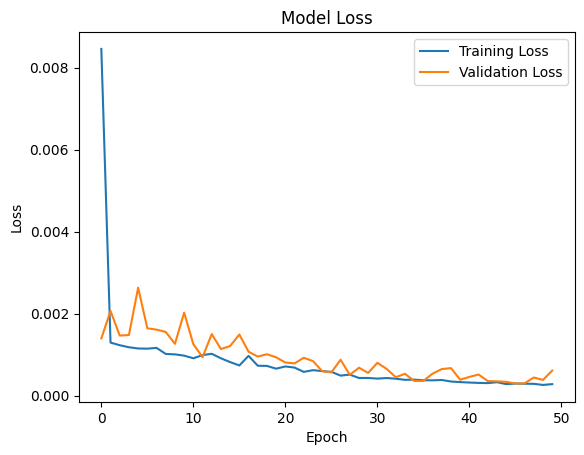

In [98]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [99]:
# 5. Vẽ đồ thị dự báo so sánh với thực tế cho từng mực nước
data_test = pd.read_csv(r'C:\Users\57\Desktop\DOANTOTNGHIEP\Data\KichBan1_2\test_data2_1.csv') 
data_test['Ngay'] = pd.to_datetime(data_test['Ngay'], format='%d/%m/%Y')
data_test.set_index('Ngay', inplace=True)
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data_test)

In [100]:
# Chuẩn hóa dữ liệu test bằng scaler đã huấn luyện
data_test_scaled = scaler.transform(data_test)

# Tạo các mẫu test từ dữ liệu test
X_test_new, y_test_new = create_sequences(data_test_scaled, n_steps)

# Định dạng lại dữ liệu test để phù hợp với mô hình
X_test_new = np.reshape(X_test_new, (X_test_new.shape[0], X_test_new.shape[1], X_test_new.shape[2]))

In [101]:
predictions_new = model.predict(X_test_new)
num_columns = data_test_scaled.shape[1]
# Chuyển đổi giá trị dự đoán và thực tế về mực nước ban đầu
predictions_new_original = scaler.inverse_transform(
    np.concatenate((predictions_new, np.zeros((predictions_new.shape[0], num_columns - predictions_new.shape[1]))), axis=1)
)[:, 0]

# Thêm đủ các cột phụ vào y_test_new để khớp với số cột của scaler
y_test_new_original = scaler.inverse_transform(
    np.concatenate((y_test_new.reshape(-1, 1), np.zeros((y_test_new.shape[0], num_columns - 1))), axis=1)
)[:, 0]

23/23 [==============================] - 1s 4ms/step


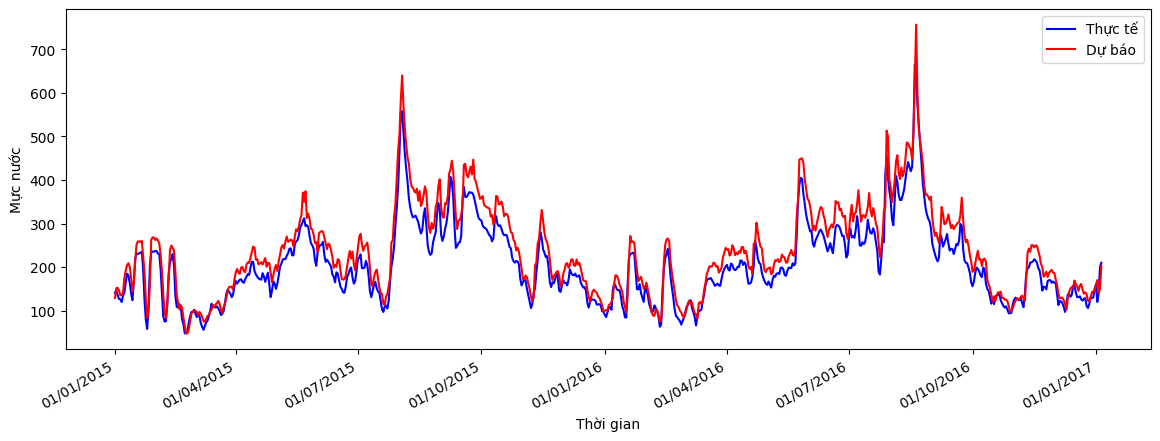

In [102]:
# Đảm bảo các mảng có cùng kích thước
import matplotlib.dates as mdates 
min_length = min(len(data_test.index), len(y_test_new_original), len(predictions_new_original))

# Cắt ngắn mảng theo độ dài nhỏ nhất
dates = data_test.index[:min_length]
y_test_new_original = y_test_new_original[:min_length]
predictions_new_original = predictions_new_original[:min_length]

# Vẽ biểu đồ
plt.figure(figsize=(14, 5))
plt.plot(dates, y_test_new_original, label='Thực tế', color='blue')
plt.plot(dates, predictions_new_original, label='Dự báo', color='red')
plt.xlabel('Thời gian')
plt.ylabel('Mực nước')

# Định dạng ngày tháng
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%Y'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()
